# Домашнее задание по курсу РСПИ
# Кузищин Дмитрий РЛ1-92
# Вариант №10

## Цель работы
Углубление понимания работы компандеров PCM сигналов, а
также принципов DPCM кодирования/декодирования в системах передачи информации.

## 1. Генерирование сигнала 
1) В представленном варианте исходным сигналом является случайный гауссовский процесс с параметрами **(0, 1/3)**

2) Используемая схема сжатия **A-law**

3) Разрядность квантователя **b = 12**

Прямой закон преобразования (функция компрессора): 
$ 
F(A, s) = \begin{cases}
  \frac{1 + \ln{A|s|}}{1 + \ln{A}} sign(s),  & \frac{1}{A} < |s| < 1 \\
  \frac{A|s|}{1 + \ln{A}} sign(s), & 0 \leq |s| \leq \frac{1}{A} 
\end{cases}
$

Обратный закон преобразования (функция экспандера): 
$ 
F^{-1}(A, y) = \begin{cases}
  \frac{1}{A} e^{|y|(1 + \ln{A})-1}sign(y),  & \frac{1}{1 + \ln{A}} < |y| < 1 \\
  \frac{1}{A}[|y|(1 + \ln{A})] sign(y), & 0 \leq |y| \leq \frac{1}{1 + \ln{A}}
\end{cases}
$

### 1.1 Подключаем модули используемые в работе

In [192]:
from collections import deque
from pandas import Series
from random import gauss
import matplotlib.pyplot as plt
import numpy as np
import math

### 1.2 Непосредственно генерируем сигнал

N - колличество отсчётов 

time_end - конец временной реализации [с]

m - математическое ожидание 

sigma - среднеквадратическое отклонение

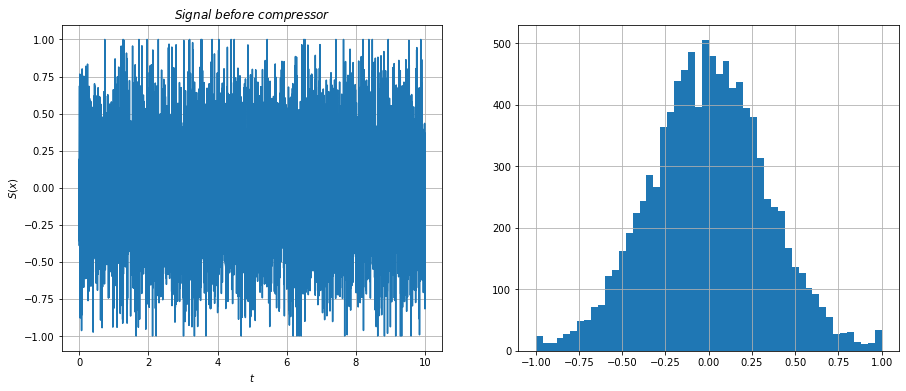

count    10001.000000
mean        -0.003488
std          0.336090
min         -1.000000
25%         -0.225360
50%         -0.003138
75%          0.219154
max          1.000000
dtype: float64


In [193]:
N = 10000
time_end = 10
m = 0.0
sigma = 1/3
series = [gauss(m,sigma) for i in range(0,N+1)]

for i in range(0,len(series)):
    if(series[i] > 1):
        series[i] = 1
    elif(series[i] < -1):
        series[i] = -1

t = [time_end/N * i for i in range(0,N+1)]
plt.figure(figsize=(15, 6))

#subplot 1
sp = plt.subplot(121)
plt.plot(t, series)
plt.xlabel(r'$t$')
plt.ylabel(r'$S(x)$')
plt.title(r'$Signal\ before\ compressor$')
plt.grid(True)

#subplot 2
sp = plt.subplot(122)
seriesStat = Series(series)
plt.grid(True)
plt.hist(seriesStat ,bins = 50)


plt.show()
print(seriesStat.describe())

Из представленных графиков видна реализация исходного сигнала, а так же по приведённой гистограмме можно сделать вывод о том, что исходный сигнала действительно подчиняется Гауссовскому закону. Ниже приведена статистика к приведённой гистограмме, подтверждающая генерацию сигнала с заданными параметрами

## 2. Функциональная схема компандирования

![Схема компандирования](circuit.png)

## 3. Прохождение сигнала по схеме компандировая

### 3.1 Реализация алгоритма компрессирования

In [194]:
def compressor(signal, parametr):
    result = []
    for i in signal:
        if(abs(i) > 1/parametr and abs(i) <= 1):
            first = (1 + math.log(abs(i) * parametr))*np.sign(i)
            second = 1 + math.log(parametr)
            result.append(first/second)
        elif(abs(i) <= 1/parametr):
            first = parametr*abs(i)*np.sign(i)
            second = 1 + math.log(parametr)
            result.append(first/second)
        else:
            print(i)
    return result

### 3.2 Прохождение сигнала через компрессор

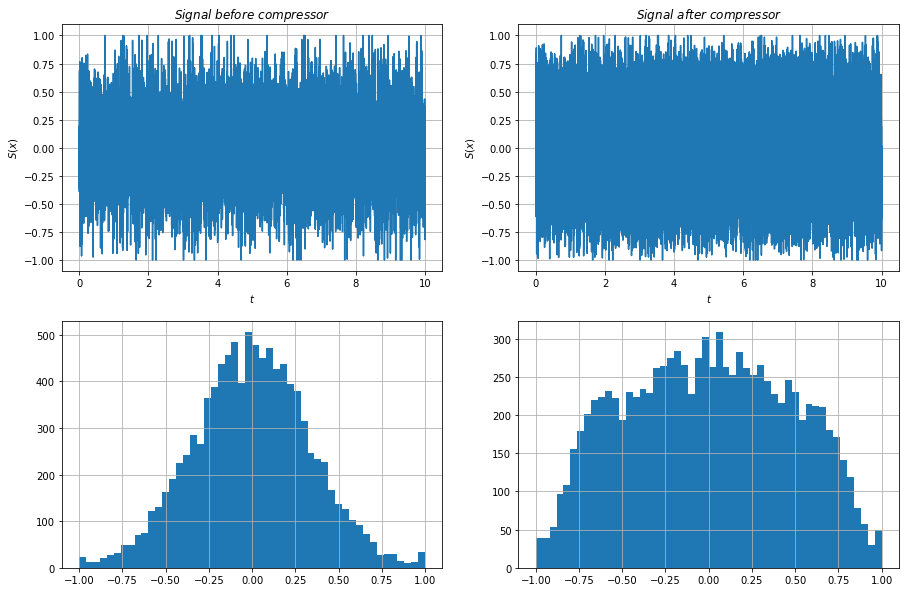

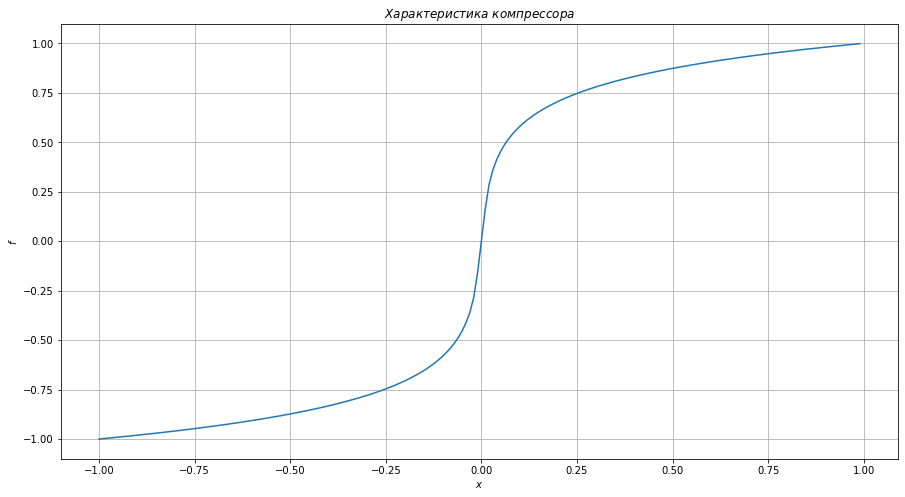

In [201]:
series_compressor = compressor(series, 4.1) #87.56
plt.figure(figsize=(15, 10))

#subplot 1
sp = plt.subplot(221)
plt.plot(t, series)
plt.xlabel(r'$t$')
plt.ylabel(r'$S(x)$')
plt.title(r'$Signal\ before\ compressor$')
plt.grid(True)

#subplot 2
sp = plt.subplot(222)
plt.plot(t, series_compressor)
plt.xlabel(r'$t$')
plt.ylabel(r'$S(x)$')
plt.title(r'$Signal\ after\ compressor$')
plt.grid(True)

#subplot 3
sp = plt.subplot(223)
seriesStat = Series(series)
plt.grid(True)
plt.hist(seriesStat ,bins = 50)

#subplot 4
sp = plt.subplot(224)
seriesStat = Series(series_compressor)
plt.grid(True)
plt.hist(seriesStat ,bins = 50)

plt.show()

plt.figure(figsize=(15, 8))
x = [-1 + i * 0.01 for i in range(0,200)]
plt.plot(x, compressor(x, 87.56))
plt.xlabel(r'$x$')
plt.ylabel(r'$f$')
plt.title(r'$Характеристика\ компрессора$')
plt.grid(True)
plt.show()


На графиках показаны гистограммы распределения значений сигналов до компрессора и после. После прохождения компрессора гистограмма распределение сигнала стремится к равномерному виду (компрессор осуществляет сжатие данных)

P.S. На нижнем графике изображёна характеристика компрессора

### 3.3 Реализация алгоритма квантования

In [196]:
def quantizer(signal, bit_depth):
    result = []
    N = 2**bit_depth              #Число уровней квантования
    delta = 1/(N-1)               #Шаг квантования если учитывать 0 как отдельный уровень
    levels = [delta*i for i in range(N)]
    for i in signal:
        for j in range(N-1):
            if(abs(i) >= levels[j] and abs(i) < levels[j+1]):
                if(abs(i) < levels[j+1] - delta/2):
                    result.append(levels[j] * np.sign(i))
                else:
                    result.append(levels[j+1] * np.sign(i))
                break
            elif(abs(i) == levels[-1]):
                result.append(levels[-1] * np.sign(i))
                break
    return result

### 3.4 Прохождение сигнала через квантователь после компрессора

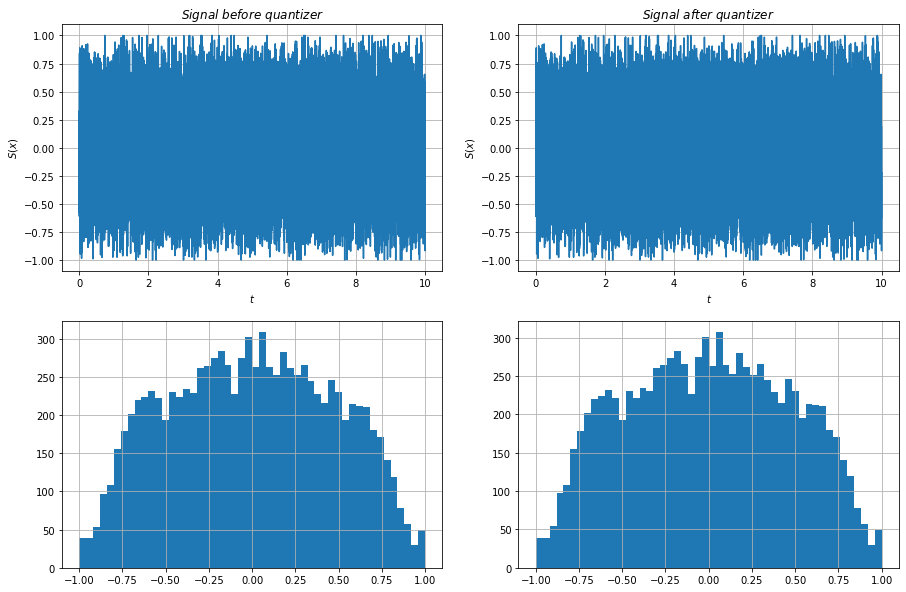

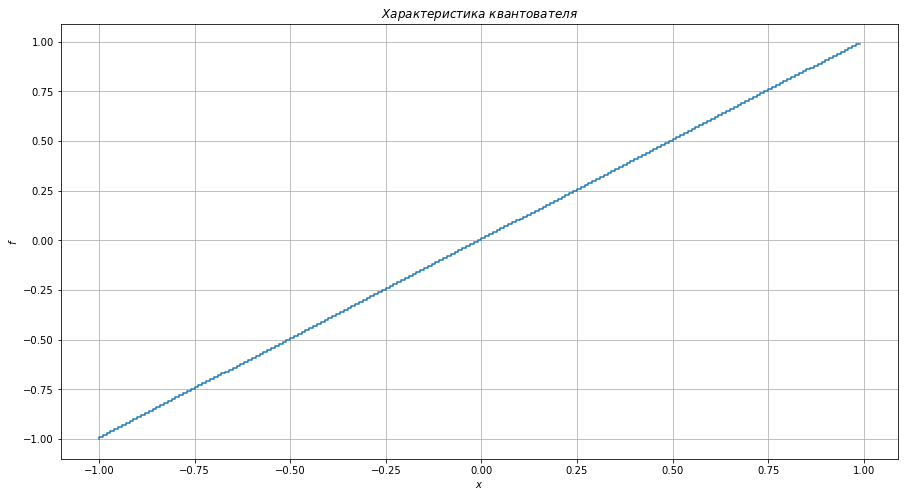

In [200]:
series_quantizer = quantizer(series_compressor, 12)
plt.figure(figsize=(15, 10))

#subplot 1
sp = plt.subplot(221)
plt.plot(t, series_compressor)
plt.xlabel(r'$t$')
plt.ylabel(r'$S(x)$')
plt.title(r'$Signal\ before\ quantizer$')
plt.grid(True)

#subplot 2
sp = plt.subplot(222)
plt.step(t, series_quantizer)
plt.xlabel(r'$t$')
plt.ylabel(r'$S(x)$')
plt.title(r'$Signal\ after\ quantizer$')
plt.grid(True)

#subplot 3
sp = plt.subplot(223)
seriesStat = Series(series_compressor)
plt.grid(True)
plt.hist(seriesStat ,bins = 50)

#subplot 4
sp = plt.subplot(224)
seriesStat = Series(series_quantizer)
plt.grid(True)
plt.hist(seriesStat ,bins = 50)

plt.show()

plt.figure(figsize=(15, 8))
x = [-1 + i * 0.01 for i in range(0,200)]
plt.step(x, quantizer(x, 12))
plt.xlabel(r'$x$')
plt.ylabel(r'$f$')
plt.title(r'$Характеристика\ квантователя$')
plt.grid(True)

plt.show()

На графиках показаны гистограммы распределения значений сигналов до квантователя и после. После прохождения квантователя гистограмма распределение сигнала практически не изменилась в силу высокой разрядности квантователя

P.S. На нижнем графике изображёна характеристика квантователя

### 3.5 Реализация алгоритма экспандирования

In [202]:
def expander(signal, parametr):
    result = []
    for i in signal:
        if(abs(i) > 1/(1 + np.log(parametr)) and abs(i) <= 1):
            result.append(1/parametr*np.sign(i)*np.exp(abs(i)*(1+np.log(parametr))-1))
        elif(abs(i) >= 0 and abs(i) <= 1/(1 + np.log(parametr))):
            result.append(1/parametr*abs(i)*(1+np.log(parametr))*np.sign(i))
        else:
            print(i)
    return result

### 3.6 Прохождение сигнала через экспандер после квантователя

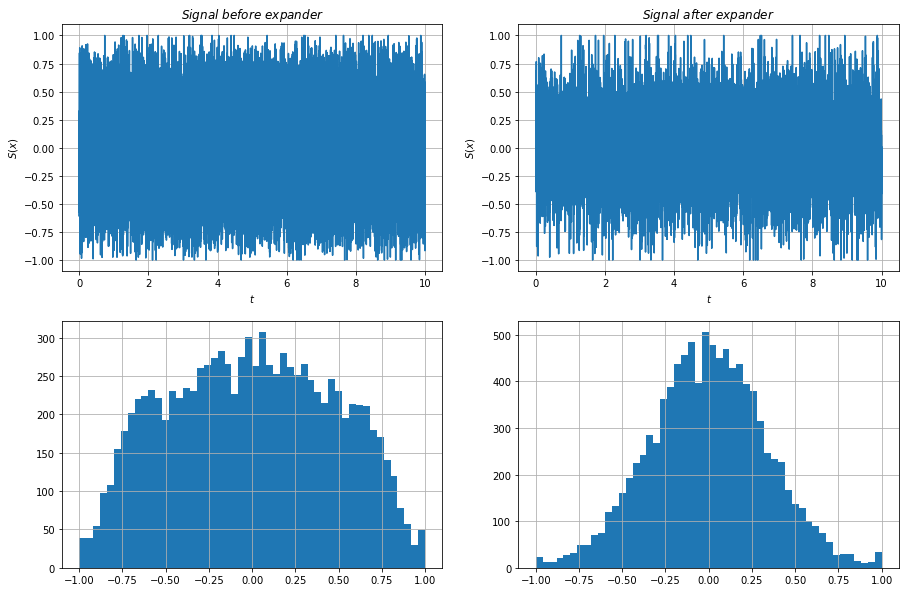

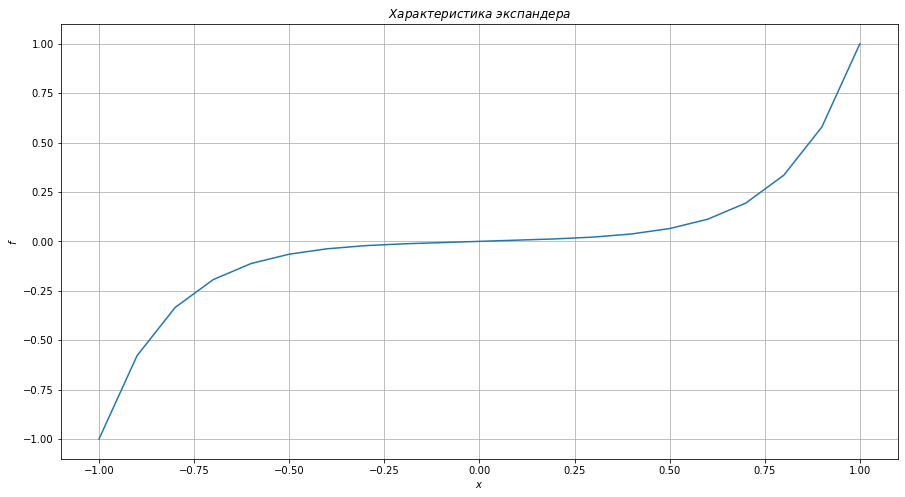

In [203]:
series_expander = expander(series_quantizer, 4.1) #87.56
plt.figure(figsize=(15, 10))

#subplot 1
sp = plt.subplot(221)
plt.step(t, series_quantizer)
plt.xlabel(r'$t$')
plt.ylabel(r'$S(x)$')
plt.title(r'$Signal\ before\ expander$')
plt.grid(True)

#subplot 2
sp = plt.subplot(222)
plt.plot(t, series_expander)
plt.xlabel(r'$t$')
plt.ylabel(r'$S(x)$')
plt.title(r'$Signal\ after\ expander$')
plt.grid(True)

#subplot 3
sp = plt.subplot(223)
seriesStat = Series(series_quantizer)
plt.grid(True)
plt.hist(seriesStat ,bins = 50)

#subplot 4
sp = plt.subplot(224)
seriesStat = Series(series_expander)
plt.grid(True)
plt.hist(seriesStat ,bins = 50)

plt.show()

plt.figure(figsize=(15, 8))
x = [i/10 for i in range(-10,11)]
plt.plot(x, expander(x, 87.56))
plt.xlabel(r'$x$')
plt.ylabel(r'$f$')
plt.title(r'$Характеристика\ экспандера$')
plt.grid(True)
plt.show()

На графиках показаны гистограммы распределения значений сигналов до экспандера и после. После прохождения экспандера гистограмма распределение сигнала приобретает первоначальный вид (экспандер осуществляет разжатие данных)

P.S. На нижнем графике изображёна характеристика экспандера

## 4. Алгоритм расчёта SQNR

### 4.1 Реализация расчёта

In [ ]:
def sqnr(signal, signal_q):
    upSum = 0
    downSum = 0
    for i in signal:
        upSum += i*i
    for i in range(0, len(signal)):
        downSum += (signal[i] - signal_q[i])*(signal[i] - signal_q[i])
    return 10*np.log10(upSum/downSum)

### 4.2 Пример использования

In [205]:
print(sqnr(series, series_expander))

series_compressor1 = compressor(series, 1) #87.56
series_quantizer1 = quantizer(series_compressor1, 12)
series_expander1 = expander(series_quantizer1, 1) #87.56

print(sqnr(series, series_expander1))

74.7623552528357
73.58167201007686


1) Первое значение соответствует SQNR для сжатия с выбранным параметром выше 

2) Второе значение соответствует SQNR в случае отсутствия компандировая

## 5. Поиск оптимального параметра сжатия 

[4.0, 4.01, 4.02, 4.03, 4.04, 4.05, 4.06, 4.07, 4.08, 4.09, 4.1, 4.11, 4.12, 4.13, 4.14, 4.15, 4.16, 4.17, 4.18, 4.19, 4.2, 4.21, 4.22, 4.23, 4.24, 4.25, 4.26, 4.27, 4.28, 4.29, 4.3, 4.31, 4.32, 4.33, 4.34, 4.35, 4.36, 4.37, 4.38, 4.39, 4.4, 4.41, 4.42, 4.43, 4.44, 4.45, 4.46, 4.47, 4.48, 4.49]


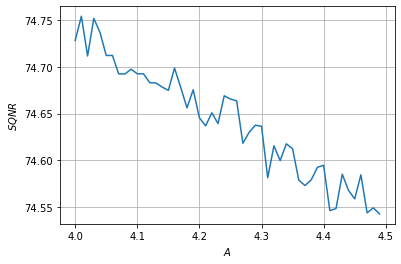

In [384]:
A_counter = [3.9 + i * 0.01 for i in range(0,40)] 
print(A_counter)
sqnr_result = []
for i in A_counter:
    series_compressor = compressor(series, i) #87.56
    series_quantizer = quantizer(series_compressor, 12)
    series_expander = expander(series_quantizer, i) #87.56
    sqnr_result.append(sqnr(series, series_expander))

plt.plot(A_counter, sqnr_result)
plt.xlabel(r'$A$')
plt.ylabel(r'$SQNR$')
plt.grid(True)
plt.show()

Как видно из представленного графика оптимальное значение параметра сжатия соответствует приблизительно **4.1**
Проведя рассуждение, можно заметить, что увеличение значения оптимального параметра сжатия связано с значением среднеквадратического отклонения исходного случаного процесса, а именно чем меньше `sigma`, тем выше концентрация элементов около нуля и тем выше становится оптимальный параметр сжатия

## 6. Сравнение исходного сигнала с компандированными (оптимальным и неоптимальным)  

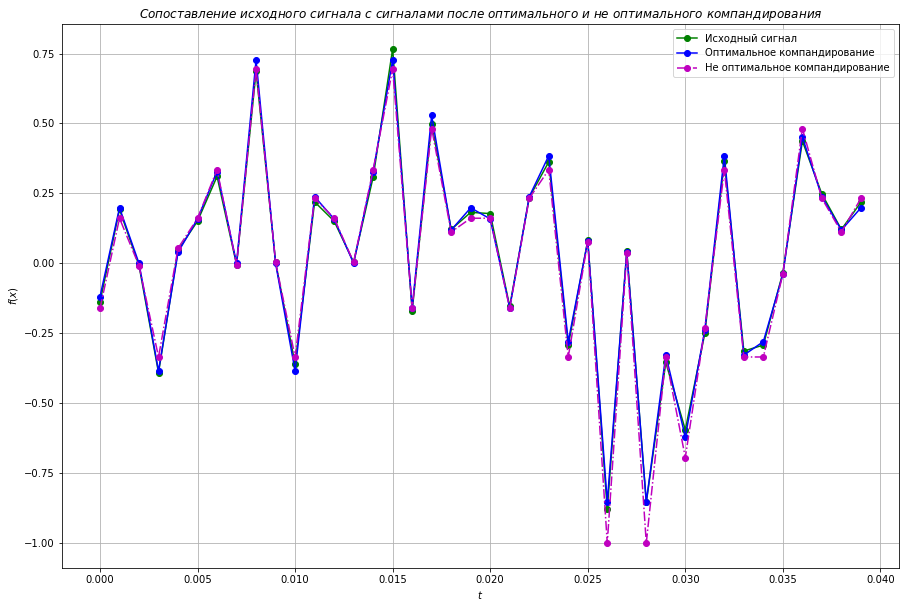

In [207]:
series_compressor1 = compressor(series[:40], 4.01) 
series_quantizer1 = quantizer(series_compressor1, 4)
series_optimum = expander(series_quantizer1, 4.01) 

series_compressor2 = compressor(series[:40], 87.6) 
series_quantizer2 = quantizer(series_compressor2, 4)
series_not_optimum = expander(series_quantizer2, 87.6) 

plt.figure(figsize=(15, 10))
plt.plot(t[:40], series[:40], 'o-g', label='Исходный сигнал')
plt.plot(t[:40], series_optimum, 'o-b', label='Оптимальное компандирование')
plt.plot(t[:40], series_not_optimum, 'o-.m', label='Не оптимальное компандирование')
plt.xlabel(r'$t$')
plt.ylabel(r'$f(x)$')
plt.title(r'$Сопоставление\ исходного\ сигнала\ с\ сигналами\ после\ оптимального\ и\ не\ оптимального\ компандирования$')
plt.legend()
plt.grid(True)
plt.show()

В результате оптимального компандирования удалось повысить исходный SQNR, так как после прохождения компрессора
распределение сигнала приобретает равномерный вид, и как следствие равномерное квантование сигнала с равномерным
распределением даёт меньшую ошибку квантования, нежели равномерное квантование сигнала с неравномерным распределением

Целевая задача компандирования сводится к подбору параметра сжатия для преобразования распределения сигнала к равномерному виду.
Далее произвести равномерно квантование (так как реализовать равномерное квантование проще нежели неравномерное). Далее 
произвести обрытную операцию (экспандирование)

P.S. Разрядность квантователя была понижена до 4 для более наглядной демонстрации различия сигналов

## 7. Функциональная схема DPCM

![Схема кодера](Кодер.png)

Алгоритм реализации кодера: 
$
e(n) = S(n)-\hat{S}(n) = S(n) - \sum_{i=1}^p a(i)s(n-i)
$


![Схема декодера](Декодер.png)

Алгоритм реализации декодера: 
$
S(n) = e(n)+\hat{S}(n) = e(n) + \sum_{i=1}^p a(i)s(n-i)
$

## 8. Реализация алгоритма кодирования/декодирования

### 8.1 Функция расчёта корреляционной функции

In [214]:
def correlationFunction(signal, N, p):
    result = []
    supSignal = deque(signal)
    for m in range(p+1):
        buffer = 0
        for i in range(N):
            buffer += signal[i] * supSignal[i]
        supSignal.pop()
        supSignal.appendleft(0)
        result.append(buffer)
    return result

### 8.2 Функция расчёт корреляционной матрицы

In [215]:
def correlationMatrix(corFunc):
    result = []
    result.append(corFunc)
    supBuf = deque()
    for m in range(1, len(corFunc)):
        supBuf.appendleft(corFunc[m])
        result.append(list(supBuf) + corFunc[:-m])
    return result

### 8.3 Функция расчёта вектора коэффициентов предсказывающего фильтра

In [216]:
def calculationA(input_signal, p):
    corFunc = correlationFunction(input_signal, len(input_signal), p)
    maximum = max(np.abs(corFunc))
    corFunc = [i/maximum for i in corFunc]
    corFunc_buf = corFunc.copy()
    corFunc_buf.pop()
    corMatrix = correlationMatrix(corFunc_buf)
    R = np.array(corMatrix)
    invR = np.linalg.inv(R)
    a = invR.dot(corFunc[1:])
    return a

### 8.4 Расчёт вектора коэффициентов предсказывающего фильтра с заданным порядком предсказания

In [217]:
p = 15
input_signal = series #series
a = calculationA(input_signal, p)
print(a)

[ 0.00804568  0.02399975 -0.01387156  0.00530478  0.00329519  0.01340113
  0.0017076   0.0006623   0.01945798 -0.00745024  0.00589194 -0.00010605
  0.00415415 -0.01779056 -0.00394008]


### 8.5 Функция предсказателя

In [218]:
def predictor(a, buffer):
    a = list(a)
    sumResult = 0
    for i in range(0,len(a)):
        sumResult += a[i] * buffer[i]
    return sumResult

### 8.6 Функция кодера

In [219]:
def coder(signal, p):
    error = []
    buffer = deque([0]*p)
    for i in range(0, len(signal)):
        if(signal[i] == signal[0]):
            error.append(quantizer([signal[i]],12)[0])
            buffer.pop()
            buffer.appendleft(signal[i])
        else:
            predic_value = predictor(a, buffer)
            conveer = signal[i] - predic_value
            if(conveer > 1):
                conveer = 1
            elif(conveer < -1):
                conveer = -1
            conveer = quantizer([conveer], 12)[0]
            error.append(conveer)
            buffer.pop()
            buffer.appendleft(predic_value + conveer)
    return error

### 8.7 Функция декодера

In [220]:
def decoder(signal, p):
    out_put = []
    buffer = deque([0]*p)
    for i in range(0, len(signal)):
        if(signal[i] == signal[0]):
            out_put.append(signal[i])
            buffer.pop()
            buffer.appendleft(signal[i])
        else:
            predic_value = predictor(a, buffer)
            out_put.append(signal[i] + predic_value)
            buffer.pop()
            buffer.appendleft(signal[i] + predic_value)
    return out_put

### 8.8 Пример работы

In [ ]:
signal_after_coder = coder(input_signal, p)
signal_after_decoder = decoder(signal_after_coder, p)

### 8.9 Сравнение исходного сигнала с кодированным и декодированным

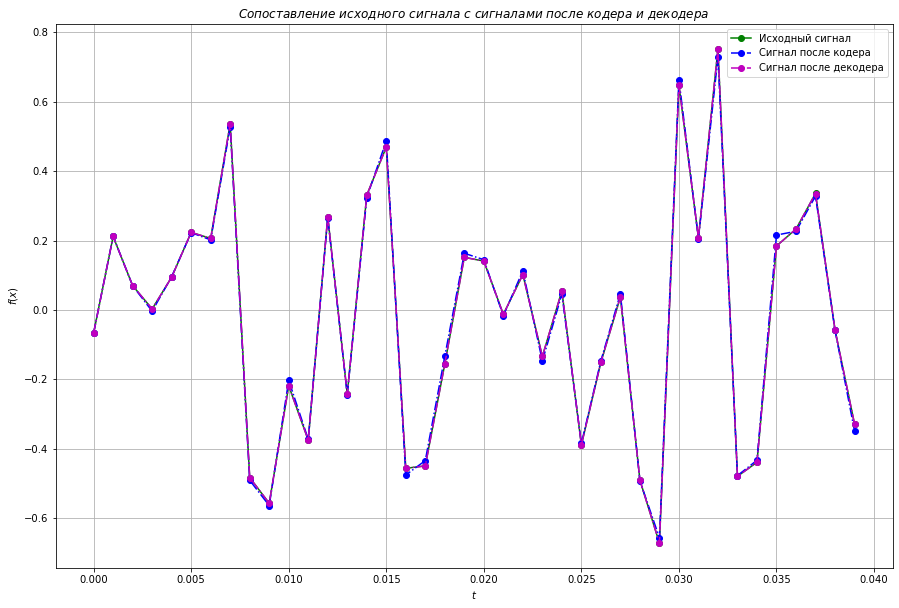

In [223]:
signal_after_coder1 = coder(input_signal[100:140], p) 
signal_after_decoder1 = decoder(signal_after_coder1, p)

plt.figure(figsize=(15, 10))
plt.plot(t[:40], input_signal[100:140], 'o-g', label='Исходный сигнал')
plt.plot(t[:40], signal_after_coder1, 'o-.b', label='Сигнал после кодера')
plt.plot(t[:40], signal_after_decoder1, 'o-.m', label='Сигнал после декодера')
plt.xlabel(r'$t$')
plt.ylabel(r'$f(x)$')
plt.title(r'$Сопоставление\ исходного\ сигнала\ с\ сигналами\ после\ кодера\ и\ декодера$')
plt.legend()
plt.grid(True)
plt.show()

Из представленных графиков можно заметить, что кодированным сигнал слабо отличается от исходного, но в тоже время декодирование проходит успешно. Происходит достаточно точное совпадение исходного и декодированного сигналов. 

Слабое отклонение кодированного сигнала от исходного вызвано малым значением вычисленных коэффициентов предсказывающего фильтра. Малое значение коэффициентов предсказания в данном случае объясняется слабой корреляцией между соседними отсчётами.
Следовательно DPCM логично использовать для сигналов, для которых присутствует немалая корреляция между соседних значений. 

## 9. Поиск оптимального порядка предсказывающего фильтра

### 9.1 Значение SQNR для выбранного порядка предсказывающего фильтра выше

In [224]:
print(sqnr(input_signal, signal_after_decoder))

54.60989726884292


### 9.2 Оптимальное значение порядка предсказывающего фильтра выше по критерий максимума SQNR

Вектор пробных значений: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


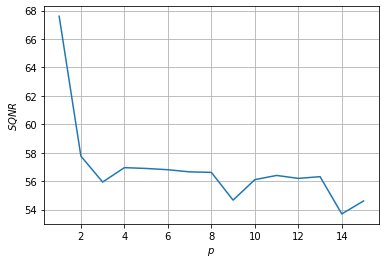

In [225]:
p_counter = [1 + i for i in range(0,15)] 
print("Вектор пробных значений: " + str(p_counter))
sqnr_result = []
for i in p_counter:
    a = calculationA(input_signal, i)
    signal_after_coder1 = coder(input_signal, i) 
    signal_after_decoder1 = decoder(signal_after_coder1, i)
    sqnr_result.append(sqnr(series, signal_after_decoder1))

plt.plot(p_counter, sqnr_result)
plt.xlabel(r'$p$')
plt.ylabel(r'$SQNR$')
plt.grid(True)
plt.show()

Из представленного графика видно, что при увеличении порядка предсказания для данного сигнала SQNR становится только хуже.
Данный результат логичен, так как связь между отсчётами достаточно слабая для гауссовского случайного процесса. И с увеличением
порядка предсказывающего фильтра, мы пытаемся учесть всё больше и больше предыдущих отсчётов и как следствие получаем большую
ошибку, а значит меньший SQNR.

## 10 Сравнение результатов компандирования и DPCM кодирования

В случае использования гауссовского случайного процесса в качастве исходного сигнала целесообразно использование компандирование, так как оно не зависит от степени корреляции между отсчётами исходного сигнала. Гассовский случайный процесс имеет слабую связь между своими соседними отсчётами, тем самым использование DPCM кодирования приведёт к малым значениям коэффициентов предсказывающего фильтра. Это в свою очередь приведёт малому различию исходного сигнала с кодированным, а значит к слабому изменению функции распределения. В данном случае равномерное квантование не будет произведено в лучшей форме. С использованием оптимального компандирования удаётся изменить функцию распределения значений сигнала до равномерной формы и произвести квантование с наименьшей ошибкой.

## 11 Оценка энтропии источников сигнала после компрессирования и после DPCM кодирования

In [229]:
series_compressor = compressor(series, 4.1)
signal_after_coder = coder(series, 3) 

s1 = series
s2 = series_compressor
s3 = signal_after_coder
bins = 1000

hist1 = np.histogram(s1, bins)
hist2 = np.histogram(s2, bins)
hist3 = np.histogram(s3, bins)

series1 = [i/N for i in hist1[0]]
series2 = [i/N for i in hist2[0]]
series3 = [i/N for i in hist3[0]]

ent1 = 0
ent2 = 0
ent3 = 0

for i in series1:
    if(abs(i) != 0):
        ent1 += -i * math.log2(abs(i))
print ("H(x) исходного сигнала " + str(ent1))

for i in series2:
    if(abs(i) != 0):
        ent2 += -i * math.log2(abs(i))
print ("H(x) компрессированного сигнала " + str(ent2))

for i in series3:
    if(abs(i) != 0):
        ent3 += -i * math.log2(abs(i))
print ("H(x) кодированного сигнала " + str(ent3))


H(x) исходного сигнала 9.338945911283435
H(x) компрессированного сигнала 9.757957310895481
H(x) кодированного сигнала 9.34681299270189


Энтропия компрессированного сигнала стала выше, чем исходного сигнала, что логично, так как задачей метода является сжатие сигнала, а значит увеличение среднего количества информации на передаваемый символ и увеличение энтропии. В случае DPCM кодирования после прохождения кодера, мы получаем квантованный сигнал ошибки между истинным отсчётом и предсказанным, следовательно диапазон данных, которые у нас могут быть уменьшился, а значит должна и уменьшиться энтропия. Однако в данном примере наблюдается незначительное увеличение энтропии по сравнению с исходным сигналом. Наблюдаемое является следствием неэффективного DPCM кодирования для данного сигнала (слабая корреляцая соседних отсчётов для Гауссовского случайного процесса)